In [6]:
import argparse, csv, os, sys
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_erosion
import matplotlib.pyplot as plt

In [42]:
temp_reg_filemane = '/Users/rushil/Downloads/6506-324_20170906_1752_ct.nii.gz'
reg_ct_img = nib.load(temp_reg_filemane)
reg_ct, = (reg_ct_img.get_fdata(dtype=np.float32),)
vox_vol = voxel_volume_ml(reg_ct_img)
stem = os.path.basename(temp_reg_filemane).replace(".nii.gz","").replace(".nii","")

Using pixdim for voxel size


In [43]:
print("Shape:", reg_ct.shape)
print("HU range:", np.min(reg_ct), "to", np.max(reg_ct))
print("Voxel volume (mL):", vox_vol)
print("Stem:", stem)


Shape: (512, 512, 56)
HU range: -1024.0 to 2120.0
Voxel volume (mL): 0.00055389404296875
Stem: 6506-324_20170906_1752_ct


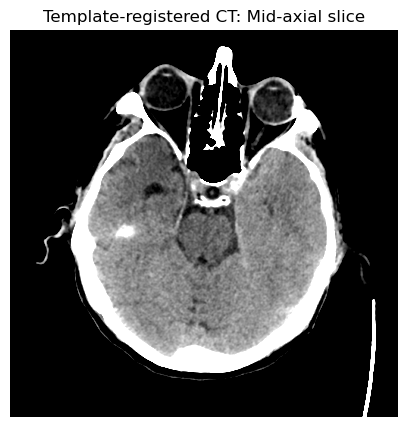

In [44]:
axial = reg_ct[:, :, 20]
plt.figure(figsize=(5, 6))
plt.imshow(axial.T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.title('Template-registered CT: Mid-axial slice')
plt.axis('off')
plt.show()

## Brain extraction using provided mask

Mask voxels: 2552132
Brain volume (mL): 1413.611
Brain HU min/median/max: -22.0 40.0 328.0
Saved: /Users/rushil/Downloads/6506-324_20170906_1752_ct_brain_extracted_from_mask.nii.gz


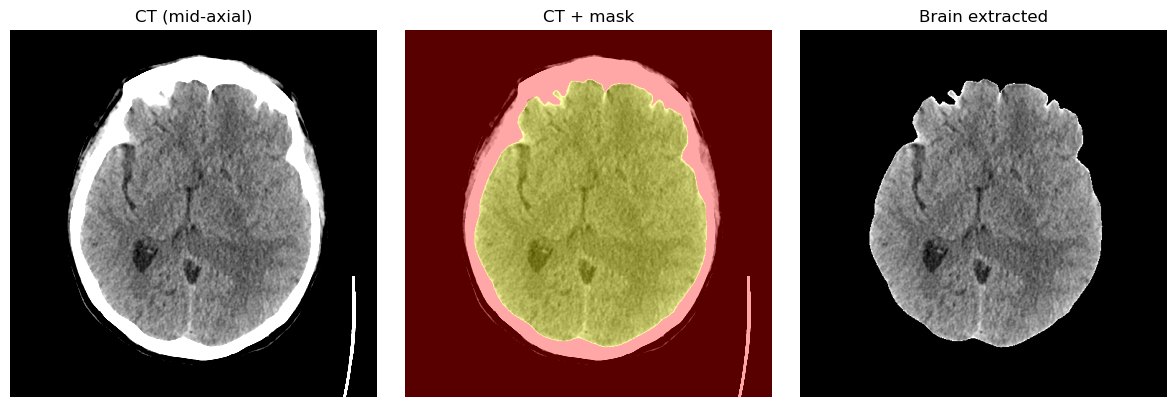

In [63]:
# Use the provided mask path to extract the brain from the registered CT
mask_path = '/Users/rushil/Downloads/6506-324_20170906_1752_ct_robust.nii.gz'

# Load mask
assert os.path.exists(mask_path), f"Mask not found: {mask_path}"
m_img = nib.load(mask_path)
m = m_img.get_fdata(dtype=np.float32)

# Resample to reg_ct space if needed
if reg_ct_img.shape != m_img.shape or not np.allclose(reg_ct_img.affine, m_img.affine, atol=1e-3):
    from nibabel.processing import resample_from_to
    r_img = resample_from_to(m_img, (reg_ct_img.shape, reg_ct_img.affine), order=0)
    m = r_img.get_fdata(dtype=np.float32)
    print('[INFO] Resampled mask to registered CT space:', m.shape)

mask_bin = m > 0.5
brain = (reg_ct * mask_bin).astype(np.float32)

# Stats
voxels = int(mask_bin.sum())
vol_ml = float(voxels * vox_vol)
print('Mask voxels:', voxels)
print('Brain volume (mL):', round(vol_ml, 3))
if voxels:
    vals = reg_ct[mask_bin]
    print('Brain HU min/median/max:', float(vals.min()), float(np.median(vals)), float(vals.max()))
else:
    print('Warning: mask seems empty after resampling/thresholding')

# Save result next to the CT
dst = os.path.join(os.path.dirname(temp_reg_filemane), f'{stem}_brain_extracted_from_mask.nii.gz')
nib.save(nib.Nifti1Image(brain, reg_ct_img.affine, reg_ct_img.header), dst)
print('Saved:', dst)

# Quick overlay for a middle axial slice
zc = reg_ct.shape[2] // 2
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(reg_ct[:, :, zc].T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.title('CT (mid-axial)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(reg_ct[:, :, zc].T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.imshow(mask_bin[:, :, zc].T, cmap='autumn', origin='lower', alpha=0.35)
plt.title('CT + mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(brain[:, :, zc].T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.title('Brain extracted')
plt.axis('off')
plt.tight_layout()
plt.show()

## Rim (boundary) overlay via mask erosion (1–2 voxels)

Rim1 voxels: 263190
Rim2 voxels: 509733


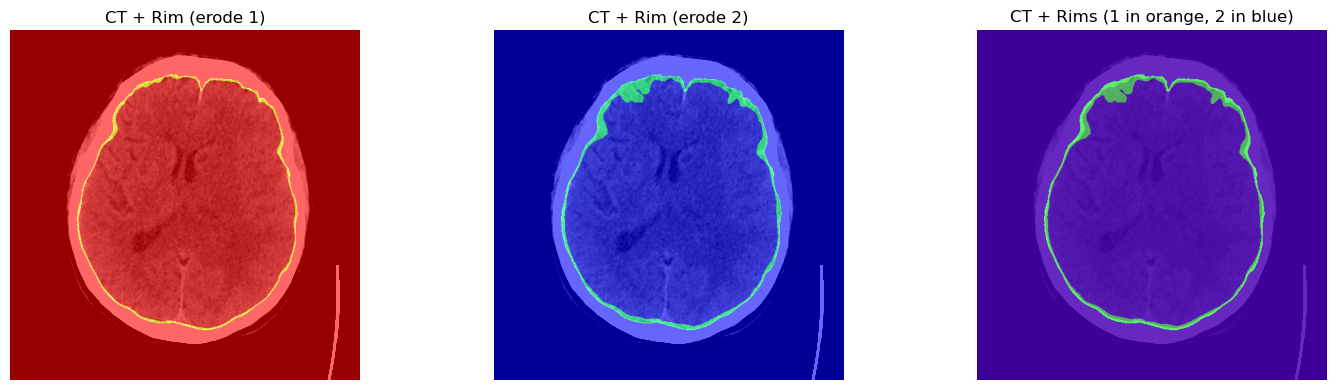

In [64]:
# Compute rim regions by erosion of the binary mask (1 and 2 voxels) and overlay on CT
from scipy.ndimage import binary_erosion

selem = np.ones((3,3,3), dtype=bool)

# Erode by 1 voxel
erode1 = binary_erosion(mask_bin, structure=selem, iterations=1)
rim1 = mask_bin & (~erode1)

# Erode by 2 voxels
erode2 = binary_erosion(mask_bin, structure=selem, iterations=2)
rim2 = mask_bin & (~erode2)

# Stats
print('Rim1 voxels:', int(rim1.sum()))
print('Rim2 voxels:', int(rim2.sum()))

# Pick mid-axial slice
zc = 30

plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
plt.imshow(reg_ct[:, :, zc].T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.imshow(rim1[:, :, zc].T, cmap='autumn', origin='lower', alpha=0.6)
plt.title('CT + Rim (erode 1)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(reg_ct[:, :, zc].T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.imshow(rim2[:, :, zc].T, cmap='winter', origin='lower', alpha=0.6)
plt.title('CT + Rim (erode 2)')
plt.axis('off')

# Combined view
plt.subplot(1,3,3)
plt.imshow(reg_ct[:, :, zc].T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.imshow(rim1[:, :, zc].T, cmap='autumn', origin='lower', alpha=0.6)
plt.imshow(rim2[:, :, zc].T, cmap='winter', origin='lower', alpha=0.6)
plt.title('CT + Rims (1 in orange, 2 in blue)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Compare rims from two algorithms on the same CT slice

Rim1 voxels: 260673
Rim2 voxels: 263190
Dice(rim1, rim2): 0.3363


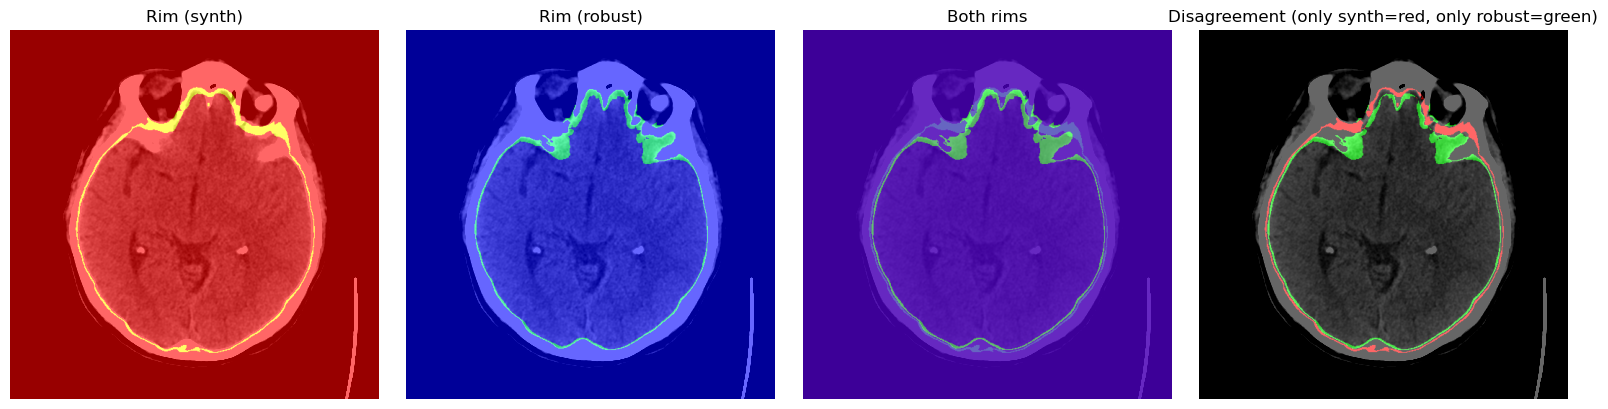

In [71]:
# Load two masks, compute 1-voxel rims, and compare on the same CT slice
from scipy.ndimage import binary_erosion
from nibabel.processing import resample_from_to

m1_path = '/Users/rushil/Downloads/6506-324_20170906_1752_ct_synth.nii.gz'
m2_path = '/Users/rushil/Downloads/6506-324_20170906_1752_ct_robust.nii.gz'

for p in (m1_path, m2_path):
    assert os.path.exists(p), f'Mask missing: {p}'

# Load and resample to CT space
m1_img = nib.load(m1_path)
m2_img = nib.load(m2_path)

if m1_img.shape != reg_ct_img.shape or not np.allclose(m1_img.affine, reg_ct_img.affine, atol=1e-3):
    m1_img = resample_from_to(m1_img, (reg_ct_img.shape, reg_ct_img.affine), order=0)
if m2_img.shape != reg_ct_img.shape or not np.allclose(m2_img.affine, reg_ct_img.affine, atol=1e-3):
    m2_img = resample_from_to(m2_img, (reg_ct_img.shape, reg_ct_img.affine), order=0)

m1 = m1_img.get_fdata(dtype=np.float32) > 0.5
m2 = m2_img.get_fdata(dtype=np.float32) > 0.5

# Compute 1-voxel rims
selem = np.ones((3,3,3), dtype=bool)
rim1 = m1 & (~binary_erosion(m1, structure=selem, iterations=1))
rim2 = m2 & (~binary_erosion(m2, structure=selem, iterations=1))

# Slice selection (use same z as earlier overlay, or center if undefined)
zc = reg_ct.shape[2] // 2
zc = 25

# Metrics
def dice(a, b):
    inter = (a & b).sum()
    denom = a.sum() + b.sum()
    return float(2*inter/denom) if denom else np.nan

print('Rim1 voxels:', int(rim1.sum()))
print('Rim2 voxels:', int(rim2.sum()))
print('Dice(rim1, rim2):', round(dice(rim1, rim2), 4))

# Overlap and disagreements on the slice for quick visualization
sl1 = rim1[:, :, zc]
sl2 = rim2[:, :, zc]
only1 = sl1 & (~sl2)
only2 = sl2 & (~sl1)
both = sl1 & sl2

plt.figure(figsize=(16, 4))

# Mask 1 rim
plt.subplot(1,4,1)
plt.imshow(reg_ct[:, :, zc].T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.imshow(sl1.T, cmap='autumn', origin='lower', alpha=0.6)
plt.title('Rim (synth)')
plt.axis('off')

# Mask 2 rim
plt.subplot(1,4,2)
plt.imshow(reg_ct[:, :, zc].T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.imshow(sl2.T, cmap='winter', origin='lower', alpha=0.6)
plt.title('Rim (robust)')
plt.axis('off')

# Combined
plt.subplot(1,4,3)
plt.imshow(reg_ct[:, :, zc].T, cmap='gray', origin='lower', vmin=0, vmax=80)
plt.imshow(sl1.T, cmap='autumn', origin='lower', alpha=0.6)
plt.imshow(sl2.T, cmap='winter', origin='lower', alpha=0.6)
plt.title('Both rims')
plt.axis('off')

# Differences (yellow = only1, cyan = only2)
plt.subplot(1,4,4)
base = reg_ct[:, :, zc].T
plt.imshow(base, cmap='gray', origin='lower', vmin=0, vmax=80)
overlay = np.zeros((*only1.T.shape, 3), dtype=float)
overlay[..., 0] = only1.T  # red channel
overlay[..., 1] = only2.T  # green channel
overlay[..., 2] = 0
plt.imshow(overlay, origin='lower', alpha=0.6)
plt.title('Disagreement (only synth=red, only robust=green)')
plt.axis('off')

plt.tight_layout()
plt.show()

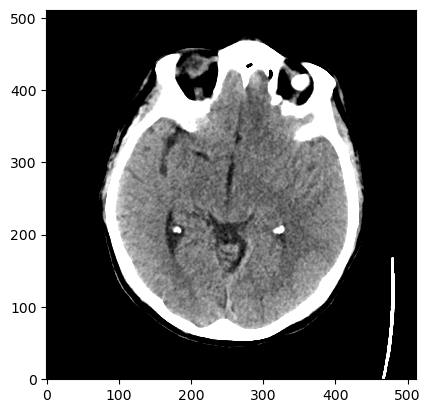

In [72]:
base = reg_ct[:, :, zc].T
plt.imshow(base, cmap='gray', origin='lower', vmin=0, vmax=80)


In [ ]:
import nibabel as nib, numpy as np
from scipy.ndimage import binary_erosion

def rim_metrics(ct_nii, mask_nii, r=1, bone=70, air=-200):
    ct_img = nib.load(ct_nii)
    mask_img = nib.load(mask_nii)
    ct = ct_img.get_fdata(dtype=np.float32)
    mask = mask_img.get_fdata().astype(bool)

    rim = mask & ~binary_erosion(mask, iterations=r)
    vals = ct[rim]
    if vals.size == 0:
        return {"empty_rim": True}

    zoom = nib.affines.voxel_sizes(ct_img.affine)  # mm
    vox_ml = float(np.prod(zoom) / 1000.0)

    rim_vol_ml  = rim.sum() * vox_ml
    vol_bone_ml = (vals >= bone).sum() * vox_ml
    vol_air_ml  = (vals <= air).sum() * vox_ml

    return {
        "empty_rim": False,
        "rim_vol_ml": rim_vol_ml,
        "p95": float(np.percentile(vals, 95)),
        "p99": float(np.percentile(vals, 99)),
        "vol_bone_ml": vol_bone_ml,
        "vol_air_ml": vol_air_ml,
        "frac_bone": float(vol_bone_ml / rim_vol_ml),
        "frac_air": float(vol_air_ml / rim_vol_ml),
        "n_rim_vox": int(vals.size),
    }

synth_metrics = rim_metrics(temp_reg_filemane, m1_path, r=1)
robust_metrics = rim_metrics(temp_reg_filemane, m2_path, r=1)

In [ ]:
synth_metrics

{'empty_rim': False,
 'rim_vol_ml': 116.9663589477539,
 'p95': 976.0,
 'p99': 1180.0,
 'vol_bone_ml': 87.46263885498047,
 'vol_air_ml': 0.4220672607421875,
 'frac_bone': 0.7477589252312108,
 'frac_air': 0.0036084500239142686,
 'n_rim_vox': 211171}

In [ ]:
robust_metrics

{'empty_rim': False,
 'rim_vol_ml': 117.09098510742187,
 'p95': 92.0,
 'p99': 99.0,
 'vol_bone_ml': 34.34807739257812,
 'vol_air_ml': 0.0,
 'frac_bone': 0.2933451910159132,
 'frac_air': 0.0,
 'n_rim_vox': 211396}

In [78]:
ct_img = nib.load(temp_reg_filemane)
slope,intercept = ct_img.dataobj.slope, ct_img.dataobj.inter
print("Slope:", slope, "Intercept:", intercept)

Slope: 1.0 Intercept: 0.0
